Hip Dysplasia Classification

v4 - Experiment One - Based on code from ...


Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import time
import numpy as np 
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from data_loader import DataGenerator

Model Architecture is a ResNET (Let's try with Keras ResNet50)

In [2]:
def resnet(HEIGHT, WIDTH, CHANNELS, NUM_OUTPUTS):
    Network = tf.keras.applications.ResNet50V2
    base_model = Network(weights = None, 
                        include_top = False, 
                        input_shape = (HEIGHT, WIDTH, CHANNELS),
                        pooling='max')
    
    for layer in base_model.layers:
        layer.trainable = True
    x = layers.Flatten()(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(NUM_OUTPUTS, activation='softmax')(x)
    model = keras.Model(inputs = base_model.input, outputs = x)
    model.base_model = base_model # Save ref to base_model 
        
    layer_count = sum([model.layers[i].name.count('conv2d') for i in range(len(model.layers))])
    print("Number of conv2d layers in the model: ", layer_count)
    print("Number of layers in the base model: ", len(base_model.layers))
    return model

Parameters

In [3]:
# Training Parameters
epochs = 200
batch_size = 128 

# Network Parameters
useTransferLearning = False
WIDTH = 256
HEIGHT = 256
CHANNELS = 3 if useTransferLearning else 1 
NUM_OUTPUTS = 2

Training 

In [4]:
'''
Trains model using input dataset. Currently uses Adam optimizer, and early stopping in training. Outputs model, train_history, and test metrics
'''

def TrainResNet(dataset):
    metrics = [
        'acc',
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    
    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1, patience=25)

    model = resnet(HEIGHT, WIDTH, CHANNELS, NUM_OUTPUTS)
    model.compile(optimizer=keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=metrics)
    model.summary()
    
    # Train and Evaluate model
    training_steps = round(data.train_size / batch_size)
    validation_steps = round(data.test_size / batch_size)
    train_history = model.fit(dataset.train_dataset, epochs=epochs, steps_per_epoch=training_steps,
            validation_data=dataset.valid_dataset,
            validation_steps=validation_steps,
            callbacks=[earlyStopping])
    
    # Evaluate Test Data 
    steps = round(data.test_size / (batch_size))
    test_metrics = model.evaluate(dataset.test_dataset, batch_size=batch_size, steps=steps)
    
    return model, train_history, test_metrics
    

Run Training

In [5]:
imagedir = '../../../../data/hip_images_marta/'
csvfilename = '../../../../data/hip_images_marta/final_data.csv'

# Generate datasets 
data = DataGenerator(width=WIDTH, height=HEIGHT, channels=CHANNELS, imagedir=imagedir, csvfilename=csvfilename, batch_size=batch_size)
print('Train Size: ' + str(data.train_size) + ' Test Size: ' + str(data.test_size))
    
# Train model 
print("Training ResNet2 ...")
start = time.time()
model, train_history, test_metrics = TrainResNet(data)
end = time.time()


  3%|██                                                                             | 28/1079 [00:00<00:03, 275.25it/s]

Loading and formating image data ....


100%|██████████████████████████████████████████████████████████████████████████████| 1079/1079 [00:38<00:00, 27.76it/s]


Training data size: Input Data (863, 500, 500, 1)  Truth Data: (863, 2)
Test data size: Input Data (216, 500, 500, 1)  Truth Data: (216, 2)
Loading and formating image data: Complete
Train Size: 863 Test Size: 216
Training ResNet2 ...
Number of conv2d layers in the model:  0
Number of layers in the base model:  191
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 3200        conv1_pad

Epoch 1/200
7/7 [==============================] - 20s 1s/step - loss: 1.0217 - acc: 0.4876 - tp: 258.8750 - fp: 268.1250 - tn: 258.8750 - fn: 268.1250 - accuracy: 0.4876 - precision: 0.4876 - recall: 0.4876 - auc: 0.5036 - prc: 0.5079 - val_loss: 0.6818 - val_acc: 0.5898 - val_tp: 151.0000 - val_fp: 105.0000 - val_tn: 151.0000 - val_fn: 105.0000 - val_accuracy: 0.5898 - val_precision: 0.5898 - val_recall: 0.5898 - val_auc: 0.6154 - val_prc: 0.5746
Epoch 2/200
7/7 [==============================] - 5s 612ms/step - loss: 0.8238 - acc: 0.5804 - tp: 309.6250 - fp: 225.6250 - tn: 309.6250 - fn: 225.6250 - accuracy: 0.5804 - precision: 0.5804 - recall: 0.5804 - auc: 0.6184 - prc: 0.6033 - val_loss: 0.7592 - val_acc: 0.2825 - val_tp: 63.0000 - val_fp: 160.0000 - val_tn: 63.0000 - val_fn: 160.0000 - val_accuracy: 0.2825 - val_precision: 0.2825 - val_recall: 0.2825 - val_auc: 0.2906 - val_prc: 0.3817
Epoch 3/200
7/7 [==============================] - 5s 634ms/step - loss: 0.8237 - acc: 0.5685 

7/7 [==============================] - 5s 618ms/step - loss: 0.0167 - acc: 0.9958 - tp: 529.1250 - fp: 2.0000 - tn: 529.1250 - fn: 2.0000 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - prc: 0.9999 - val_loss: 1.6666 - val_acc: 0.6641 - val_tp: 170.0000 - val_fp: 86.0000 - val_tn: 170.0000 - val_fn: 86.0000 - val_accuracy: 0.6641 - val_precision: 0.6641 - val_recall: 0.6641 - val_auc: 0.6718 - val_prc: 0.6373
Epoch 20/200
7/7 [==============================] - 5s 625ms/step - loss: 0.0196 - acc: 0.9960 - tp: 529.1250 - fp: 2.0000 - tn: 529.1250 - fn: 2.0000 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - prc: 0.9998 - val_loss: 1.8441 - val_acc: 0.6133 - val_tp: 157.0000 - val_fp: 99.0000 - val_tn: 157.0000 - val_fn: 99.0000 - val_accuracy: 0.6133 - val_precision: 0.6133 - val_recall: 0.6133 - val_auc: 0.6505 - val_prc: 0.6240
Epoch 21/200
7/7 [==============================] - 5s 629ms/step - loss: 0.0160 - acc: 0.9978 - tp: 546.1250 - f

In [6]:
 train_history.history.keys()

dict_keys(['loss', 'acc', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_acc', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc'])

Ploting and Saving

In [5]:
'''
Plots metric history data for training a model 
'''
def plot(data, model_name, summary, file_time):
    # Plot Accuracy / Loss 
    fig, axs = plt.subplots(2)
    fig.suptitle(model_name + ': ' + summary)

    axs[0].plot(data[0].history['acc'])
    axs[0].plot(data[0].history['val_acc'])
    axs[0].set_ylabel('acc')
    axs[0].legend(["Train", "Test"], loc="lower right")

    axs[1].plot(data[0].history['loss'])
    axs[1].plot(data[0].history['val_loss'])
    axs[1].set_ylabel('loss')
    axs[1].legend(["Train", "Test"], loc="upper right")
    
    #plt.show()
    plt.savefig('hip_classify_' + model_name + file_time + '.png')

'''
Saves training and test metrics to metrics.npy
'''
def save_metrics(model_name, history, metrics, file_time):
    fname = 'metrics' + file_time + '.npy' 
    fileExists = os.path.isfile(fname)
    if(fileExists):
        data = np.load(fname, allow_pickle=True)[()]
        data[model_name] = { 'train_history': history.history, 'test_metrics': metrics }
    else:
        data = { model_name: { 'train_history': history.history, 'test_metrics': metrics } }
    
    np.save(fname, data)

Plot and Save Results

ResNet: Loss: 0.082939, Accuracy: 0.972656, Time: 2302.78s


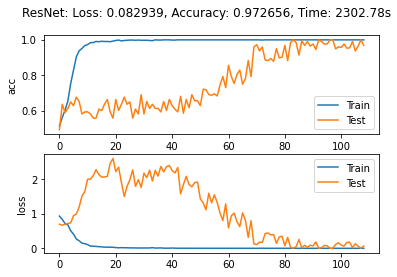

In [7]:
import datetime
file_time = datetime.datetime.today().strftime('_%Y-%m-%d__%I-%M')

# Plot and Output results
summary = 'Loss: %.6f, Accuracy: %.6f, Time: %.2fs' % (test_metrics[0], test_metrics[1], (end - start))
print('ResNet: ' + summary)
plot([train_history], 'ResNet', summary, file_time)

# Save train_history and test_metrics
test_metrics = { 'loss': test_metrics[0], 'acc': test_metrics[1], 'time': (end - start) }
save_metrics('ResNet', train_history, test_metrics, file_time)

# Save model
model.save('v4_resnet_' + file_time + '.h5', save_format='tf')